In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from IPython.display import Markdown, display,HTML,Image
from z3 import *

<img src="https://www.janestreet.com/puzzles/20180102_sudoku.png" width="450">

In [2]:
# 50 mins with my numba enhanced backtracking
# less than 0.4 of a sec with z3

# Setup the constraints
fixed = np.array([[ 0, 0, 9, 0, 0, 9,49, 0, 0],
                  [ 9, 0,25, 0, 0, 0,36, 0, 0],
                  [49, 0, 0,36,16, 9, 0,81,25],
                  [ 4,49, 0, 1, 0, 0, 9, 0,81],
                  [ 0, 0,81, 0, 0, 0,16, 0, 0],
                  [ 9, 0,64, 0, 0, 4, 0, 4, 6],
                  [36,16, 0,16, 4,25, 0, 0,49],
                  [ 0, 0,49, 0, 0, 0, 9, 0, 4],
                  [ 0, 0,36,49, 0, 0,16, 0, 0]],dtype=int)

In [3]:
def score(solution):
    return  np.sum((solution[fixed!=0]**2))

def sol_print(solution):
    x= np.ones((3,3))
    groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    y = (fixed > 0) + groups*2
    ax = sns.heatmap(y,annot=solution,cbar=False,cmap="tab20",fmt="",linewidths=2,annot_kws={"size":14})
    ax.axis("off")

In [4]:
def neighs(i,j,X):   
    neigh = [(0,-1),(0,1),(1,0),(-1,0)]    
    between = lambda x: x>=0 and x<9
    return [X[i+x,j+y] for x,y in neigh if between(i+x)and between(j+y)]

def z3_sudoku(grid,fixed):
    # 9x9 matrix of integer variables
    X = np.array(IntVector("x",9*9),dtype=object).reshape((9,9))
    s = Tactic('qffd').solver()

    # numbers are between 1 & 9
    s += [And(e > 0  ,e <=9) for _,e in np.ndenumerate(X)]

    # rows & columns distinct
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if i == n]) for n in range(9)])
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if j == n]) for n in range(9)])

    # groups distinct
    x= np.ones((3,3))
    groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if groups[i,j] == n]) for n in range(9)])

    # neighbours condition
    s += [Or([a * b == int(e) for (a,b) in itertools.combinations(neighs(i,j,X),2)]) 
             for (i,j),e in np.ndenumerate(fixed) if e > 0]
                    
    start = time.time()
    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        r = evalu(X)
        display(Markdown("Answer is **{}**.Took {:.4f} seconds".format(score(r),time.time()-start)))
        sol_print(np.array(r))
    else:
        print("Failed in {} seconds".format(time.time()-start))

Answer is **1146**.Took 0.3770 seconds

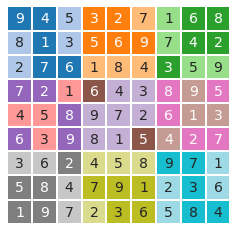

In [9]:
z3_sudoku(np.zeros((9,9)),fixed)

### Solution as published 
https://www.janestreet.com/puzzles/rather-square-sudoku-solution/

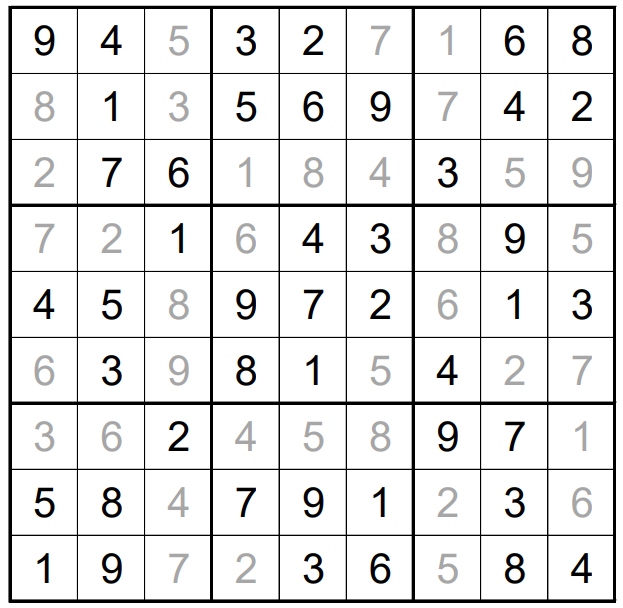

In [6]:
url='https://www.janestreet.com/puzzles/rather-square-sudoku-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))

display(HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1])))
display(Image('https://www.janestreet.com/puzzles/20180201_sudoku_ans.png',width=250))

In [7]:
correct= np.array([[9,4,5,3,2,7,1,6,8],
                   [8,1,3,5,6,9,7,4,2],
                   [2,7,6,1,8,4,3,5,9],
                   [7,2,1,6,4,3,8,9,5],
                   [4,5,8,9,7,2,6,1,3],
                   [6,3,9,8,1,5,4,2,7],
                   [3,6,2,4,5,8,9,7,1],
                   [5,8,4,7,9,1,2,3,6],
                   [1,9,7,2,3,6,5,8,4]] 
                  ,dtype=int)